<a href="https://colab.research.google.com/github/datasigntist/byteSizedLearn/blob/master/Movie_Genre_Classification_based_on_Poster_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Experiments with CNN -- Movie Genre Classification based on Poster Images**

Author : Vishwanathan Raman

EmailId : datasigntist@gmail.com

Description : 

In this notebook we are going to develop a deep neural network (CNN) to solve the problem of movie genre classification based on movie poster images.

Data Source : https://www.cs.ccu.edu.tw/~wtchu/projects/MoviePoster/index.html


Reference Links: 

If you are new to Convolution and Pooling concepts 

*   Play with this notebook https://colab.research.google.com/drive/1_s6r49qhhk6kDCCDhKYsnBU_fjiQILB0 which gives you a view of how Convolution and Pooling works

*   Please also go through the videos by Andrew NG at 
https://www.youtube.com/playlist?list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF . The playlist is long but you can hop onto this experiment once you are done till C4W1L11, that will give you a good foundation on Convolution and Pooling







# **Tensorflow Installation (Optional)**

This experiment is built on tensorflow 2.0 gpu, run a quick check to see the current version, if its not 2.0 then uninstall the current version and install the 2.0 gpu version

In [0]:
import tensorflow as tf
print(tf.__version__)

1.14.0


In [0]:
!pip uninstall tensorflow 

Uninstalling tensorflow-1.14.0:
  Would remove:
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-1.14.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.14.0


In [0]:
!pip install tensorflow-gpu

     |████████████████████████████████| 380.8MB 46kB/s 
     |████████████████████████████████| 450kB 41.5MB/s 
     |████████████████████████████████| 3.8MB 35.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=4f1a7af9f1505e872930bf66f66f98e75b04358f97024ab659c356231e116398
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: tensorflow-estimator 1.14.0
    Uninstalling tensorflow-estimator-1.14.0:
      Successfully uninstalled tensorflow-estimator-1.14.0
  Found existing installation: tensorboard 1.14.0
    Uninstalling tensorboard-1.14.0:
      Successfully uninstalled tensorboard-1.14.0
  Found existing installation: gast 0.3.2
    Uninstalling gast-0.3.2:
      Successfully uninstalled gast-0.3.2


# **Importing Libraries**

In [0]:
import os
import zipfile
import random
import tensorflow as tf
import shutil
import csv
import numpy as np
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import pandas as pd
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# **Dataset**

The dataset is sourced from https://www.cs.ccu.edu.tw/~wtchu/projects/MoviePoster/index.html . This is relatively large dataset. The best way to access this dataset is to download and upload it to your google drive. If you try uploading it google colab directly it might take ages for you to upload hence google drive is the best option. Once uploaded to google drive, access the google drive from google colab seamless through a library. The dataset can then be downloaded to google colab tmp directory through wget. 

There are 2 datasets

1.   Metadata
2.   Poster Data



In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls '/content/drive/My Drive/Data Dumps/Movie Posters'

Movie_Poster_Dataset.zip  Movie_Poster_Metadata.zip


## **Downloading Moster Poster Metadata**

In [0]:
metadata_dir = '/tmp/moviepostersmetadata'
os.mkdir(metadata_dir)

In [0]:
local_zip = '/content/drive/My Drive/Data Dumps/Movie Posters/Movie_Poster_Metadata.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/moviepostersmetadata')
zip_ref.close()

## **Building a Master File List**

In [0]:
!ls '/tmp/moviepostersmetadata/groundtruth' > fileList.txt

In [0]:
fileList = []
with open("/content/fileList.txt") as f:
  for line in f:
    fileList.append(line.strip())

In [0]:
print("The number of files in metadata",len(fileList))

The number of files in metadata 36


## **Donwnloading Movies Posters**

All the movie posters have been placed in individual directories that reflect the year of the release

In [0]:
moviepostersdata_dir = '/tmp/moviepostersdata'
os.mkdir(moviepostersdata_dir)

In [0]:
local_zip = '/content/drive/My Drive/Data Dumps/Movie Posters/Movie_Poster_Dataset.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/moviepostersdata')
zip_ref.close()

## **Data Consolidation**

A a single directory to consolidate all the posteres

In [0]:
allmoviepostersdata_dir = '/tmp/allmoviepostersdata'
os.mkdir(allmoviepostersdata_dir)

## **Master File List Table**

Iterate through all the metadata files and build a single master table. As you can see the that there are no posters for 1982 which needs be taken into account. Essentially there could be metadata for non existent poster files or there could be poster files for which there is no metadata. This data anomaly has to be factored in while processing the files.

In [0]:
moviePosterCount = []
movieYear = []
moviePosterFile = []
for loop in range(len(fileList)):
  dirName = os.path.join('/tmp/moviepostersdata/Movie_Poster_Dataset',fileList[loop].replace(".txt",""))
  imageFileList = os.listdir(dirName)
  print('DirName:',dirName,' Year:',fileList[loop].replace(".txt",""),':',len(imageFileList))
  moviePosterCount.append(len(imageFileList))
  movieYear.append(fileList[loop].replace(".txt",""))
  for file in imageFileList:
    moviePosterFile.append(file)

DirName: /tmp/moviepostersdata/Movie_Poster_Dataset/1980  Year: 1980 : 96
DirName: /tmp/moviepostersdata/Movie_Poster_Dataset/1981  Year: 1981 : 89
DirName: /tmp/moviepostersdata/Movie_Poster_Dataset/1982  Year: 1982 : 0
DirName: /tmp/moviepostersdata/Movie_Poster_Dataset/1983  Year: 1983 : 114
DirName: /tmp/moviepostersdata/Movie_Poster_Dataset/1984  Year: 1984 : 134
DirName: /tmp/moviepostersdata/Movie_Poster_Dataset/1985  Year: 1985 : 150
DirName: /tmp/moviepostersdata/Movie_Poster_Dataset/1986  Year: 1986 : 169
DirName: /tmp/moviepostersdata/Movie_Poster_Dataset/1987  Year: 1987 : 187
DirName: /tmp/moviepostersdata/Movie_Poster_Dataset/1988  Year: 1988 : 201
DirName: /tmp/moviepostersdata/Movie_Poster_Dataset/1989  Year: 1989 : 180
DirName: /tmp/moviepostersdata/Movie_Poster_Dataset/1990  Year: 1990 : 167
DirName: /tmp/moviepostersdata/Movie_Poster_Dataset/1991  Year: 1991 : 171
DirName: /tmp/moviepostersdata/Movie_Poster_Dataset/1992  Year: 1992 : 175
DirName: /tmp/moviepostersdat

In [0]:
movieListDatabase = pd.DataFrame({'MovieYear':movieYear,'MoviePosterCount':moviePosterCount})

In [0]:
movieListDatabase.head()

MovieYear  MoviePosterCount
0      1980                96
1      1981                89
2      1982                 0
3      1983               114
4      1984               134

In [0]:
print("As per the metadata there has to be ",movieListDatabase["MoviePosterCount"].sum()," movie posters")

As per the metadata there has to be  8052  movie posters


## **Iterating through the Metadata to extract other relevant information**

Here is a quick and dirty version of reading the corresponding metadata files. During exploratory analysis, found some differences in the file metadata. Prior to 1982 the files could be read using "utf-8" while others could be read only using "utf-16". This is not the best code but serves the purpose of collecting relevant information.

In [0]:
movieList = []
movieDict ={}
count = 0
for loop in range(len(fileList)):
  recCount = 0
  if (movieListDatabase["MoviePosterCount"][loop]>0):
    recCount = 0
    fileName = os.path.join('/tmp/moviepostersmetadata/groundtruth',fileList[loop])
    try:
      with open(fileName,encoding='utf-8') as f:
          for line in f:
            modline = line.strip()
            if (modline=="{"):
              movieDict["Year"] = fileList[loop].replace(".txt","").strip()
              count = count+1
            elif (modline=="}"):
              movieList.append(movieDict)
              movieDict ={}
              count = count-1
            else:
              movieDict[modline.split(":")[0].replace('"', '').strip()] = modline.split(":")[1].replace('"', '').strip()
              recCount = recCount+1
    except:
        with open(fileName,encoding='utf-16') as f:
          for line in f:
            modline = line.strip()
            if (modline=="{"):
              movieDict["Year"] = fileList[loop].replace(".txt","").strip()
              count = count+1
            elif (modline=="}"):
              movieList.append(movieDict)
              movieDict ={}
              count = count-1
            else:
              movieDict[modline.split(":")[0].replace('"', '').strip()] = modline.split(":")[1].replace('"', '').strip()
              recCount = recCount+1

In [0]:
movieList[1]

{'Actors': 'Gene Wilder, Richard Pryor, Georg Stanford Brown, JoBeth Williams,',
 'Awards': '1 nomination.,',
 'Box_office': '101,500,000,',
 'Country': 'USA,',
 'Director': 'Sidney Poitier,',
 'Genre': 'Comedy, Crime,',
 'Language': 'English,',
 'Metascore': '50',
 'Poster': 'http',
 'Rated': 'R,',
 'Released': '12 Dec 1980,',
 'Response': 'True,',
 'Runtime': '111 min,',
 'Title': 'Stir Crazy,',
 'Type': 'movie,',
 'Writer': 'Bruce Jay Friedman,',
 'Year': '1980',
 '_id': 'ObjectId(56fb860e71a0651b0c306f56),',
 'imdbID': 'tt0081562,',
 'imdbRating': '6.8,',
 'imdbVotes': '17,705,'}

## **Building the database of actual existent files**

Iterates through the movieList and find if there is a corresponding movie poster file existent. If its existent it moves them to the new directory that was created to place all the movie posters.

In [0]:
mainPosterDirectory = '/tmp/moviepostersdata/Movie_Poster_Dataset'
allmoviepostersdata_dir = '/tmp/allmoviepostersdata'
scrubbedMovieList = []
newFileList = []
for loop in range(len(movieList)):
  filePosterDirectory = os.path.join(mainPosterDirectory,movieList[loop]['Year'])
  fileName = movieList[loop]["imdbID"].replace(",","").strip()
  actualFileName = os.path.join(filePosterDirectory,fileName)+".jpg"
  if (len([file for file in newFileList if file==fileName])==0):
    newFileList.append(fileName)
    if(os.path.isfile(actualFileName)):
      scrubbedMovieList.append(movieList[loop])
      destFileName = movieList[loop]["imdbID"].replace(",","").strip()+".jpg"
      destFileNameWithPath = os.path.join(allmoviepostersdata_dir,destFileName)
      shutil.copyfile(actualFileName,destFileNameWithPath)

In [0]:
print("Size of scrubbedMovieList is ",len(scrubbedMovieList))

Size of scrubbedMovieList is  8052


In [0]:
allGenreList = []
for loop in range(len(scrubbedMovieList)):
  allGenreList.append(','.join([elem for elem in scrubbedMovieList[loop]['Genre'].split(",") if elem!=""]))

In [0]:
print(allGenreList)

['Action, Adventure, Fantasy', 'Comedy, Crime', 'Comedy', 'Action, Comedy', 'Comedy, War', 'Biography, Drama, Music', 'Action, Comedy', 'Adventure, Drama, Romance', 'Action, Comedy, Crime', 'Drama', 'Adventure, Comedy, Family', 'Drama, Romance, Western', 'Drama, Horror', 'Comedy, Romance', 'Comedy, Crime, Sci-Fi', 'Comedy, Sport', 'Drama', 'Comedy, Drama', 'Mystery, Thriller', 'Drama, Music, Romance', 'Action, Adventure, Sci-Fi', 'Biography, Drama', 'Action, Adventure, Comedy', 'Biography, Drama, Sport', 'Fantasy, Musical, Romance', 'Crime, Drama, Mystery', 'Comedy, Drama, Family', 'Fantasy, Horror', 'Horror, Sci-Fi, Thriller', 'Crime, Mystery, Thriller', 'Action, Drama, Romance', 'Music, Romance, Drama', 'Adventure, Comedy, Family', 'Adventure, Comedy, Crime', 'Action, Sci-Fi', 'Action, Biography, Comedy', 'Comedy, Romance', 'Western', 'Comedy', 'Horror, Romance', 'Comedy, Crime, Mystery', 'Comedy, Fantasy', 'Drama, Romance, Music', 'Comedy, Fantasy, History', 'Comedy', 'Comedy', 'Cri

In [0]:
fileNameList =[elem["imdbID"].replace(",","").strip()+".jpg" for elem in scrubbedMovieList]

In [0]:
print(fileNameList)

['tt0080684.jpg', 'tt0081562.jpg', 'tt0080339.jpg', 'tt0080377.jpg', 'tt0081375.jpg', 'tt0080549.jpg', 'tt0081529.jpg', 'tt0080453.jpg', 'tt0080455.jpg', 'tt0081283.jpg', 'tt0081353.jpg', 'tt0081696.jpg', 'tt0081505.jpg', 'tt0081480.jpg', 'tt0080520.jpg', 'tt0080487.jpg', 'tt0080474.jpg', 'tt0081060.jpg', 'tt0080661.jpg', 'tt0080948.jpg', 'tt0080745.jpg', 'tt0080678.jpg', 'tt0080472.jpg', 'tt0081398.jpg', 'tt0081777.jpg', 'tt0080365.jpg', 'tt0081207.jpg', 'tt0080749.jpg', 'tt0080360.jpg', 'tt0080569.jpg', 'tt0081259.jpg', 'tt0080888.jpg', 'tt0080861.jpg', 'tt0081439.jpg', 'tt0080736.jpg', 'tt0080907.jpg', 'tt0080863.jpg', 'tt0081071.jpg', 'tt0080739.jpg', 'tt0081383.jpg', 'tt0081249.jpg', 'tt0081268.jpg', 'tt0080556.jpg', 'tt0081751.jpg', 'tt0081032.jpg', 'tt0081698.jpg', 'tt0081163.jpg', 'tt0081031.jpg', 'tt0080731.jpg', 'tt0081554.jpg', 'tt0080881.jpg', 'tt0081485.jpg', 'tt0081534.jpg', 'tt0081656.jpg', 'tt0079285.jpg', 'tt0080754.jpg', 'tt0080402.jpg', 'tt0080724.jpg', 'tt0080756.jp

In [0]:
movieListDatabase = pd.DataFrame({'FileNames':fileNameList,'Genres':allGenreList})

In [0]:
movieListDatabase.head()

FileNames                      Genres
0  tt0080684.jpg  Action, Adventure, Fantasy
1  tt0081562.jpg               Comedy, Crime
2  tt0080339.jpg                      Comedy
3  tt0080377.jpg              Action, Comedy
4  tt0081375.jpg                 Comedy, War

In [0]:
movieListDatabase["Genres"]=movieListDatabase["Genres"].apply(lambda x:x.split(","))

In [0]:
movieListDatabase.head()

FileNames                          Genres
0  tt0080684.jpg  [Action,  Adventure,  Fantasy]
1  tt0081562.jpg                [Comedy,  Crime]
2  tt0080339.jpg                        [Comedy]
3  tt0080377.jpg               [Action,  Comedy]
4  tt0081375.jpg                  [Comedy,  War]

In [0]:
genreList = ""
for loop in range(len(scrubbedMovieList)):
  if (genreList==""):
    genreList = scrubbedMovieList[loop]['Genre']
  else:
    genreList = genreList+","+scrubbedMovieList[loop]['Genre']

In [0]:
genreSet = [elem.strip() for elem in genreList.split(',') if elem!=""]

In [0]:
genreSet = set(genreSet)

In [0]:
genreSetList = list(genreSet)

In [0]:
genreSetList.sort()

In [0]:
print(genreSetList)

['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'N/A', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']


## **Creating a movie list having 1 Genre**

Selecting the 1st Genre as Genre of the movie

In [0]:
movieListDatabase1Genre = movieListDatabase

In [0]:
movieListDatabase1Genre["Genres"] = [elem[0] for elem in movieListDatabase["Genres"]]

In [0]:
movieListDatabase1GenreStats = movieListDatabase1Genre.groupby("Genres").size().reset_index(name="counts")

In [0]:
movieListDatabase1GenreStats = movieListDatabase1GenreStats.sort_values("counts",ascending=False)

In [0]:
movieListDatabase1GenreStats

Genres  counts
4        Comedy    2409
7         Drama    1565
0        Action    1392
6   Documentary     729
5         Crime     444
1     Adventure     359
3     Biography     336
2     Animation     264
11       Horror     249
9       Fantasy      60
22     Thriller      46
20        Short      42
14      Mystery      33
18      Romance      31
8        Family      28
19       Sci-Fi      17
13      Musical      12
15          N/A      11
12        Music       8
24      Western       7
23          War       5
10      History       2
17   Reality-TV       1
16         News       1
21        Sport       1

In [0]:
listForFilter = list(movieListDatabase1GenreStats[movieListDatabase1GenreStats["counts"]>100]["Genres"])

In [0]:
movieListDatabase1GenreFiltered = movieListDatabase1Genre[movieListDatabase1Genre["Genres"].isin(listForFilter)]

In [0]:
movieListDatabase1GenreFiltered.shape

(7747, 2)

In [0]:
sampleForValidation = movieListDatabase1GenreFiltered.groupby('Genres').apply(lambda x: x.sample(frac=.005))

In [0]:
fileListForValidation = [fileName for fileName in sampleForValidation["FileNames"]]

In [0]:
len(fileListForValidation)

39

In [0]:
validationData = movieListDatabase1GenreFiltered[movieListDatabase1GenreFiltered["FileNames"].isin(fileListForValidation)]

In [0]:
validationData.shape

(39, 2)

In [0]:
validationData.tail(10)

FileNames       Genres
6687  tt1855199.jpg        Crime
6784  tt2178508.jpg       Action
7015  tt2334879.jpg       Action
7169  tt2436516.jpg       Action
7211  tt2016940.jpg       Action
7290  tt2419284.jpg  Documentary
7618  tt3093520.jpg  Documentary
7817  tt3863552.jpg       Comedy
7828  tt1772288.jpg       Comedy
7893  tt4572856.jpg       Comedy

In [0]:
trainData = movieListDatabase1GenreFiltered[~movieListDatabase1GenreFiltered["FileNames"].isin(fileListForValidation)]

In [0]:
trainData.shape

(7708, 2)

In [0]:
movieListDatabase.shape

(8052, 2)

## **Viewing the Posters and the respective Genres**

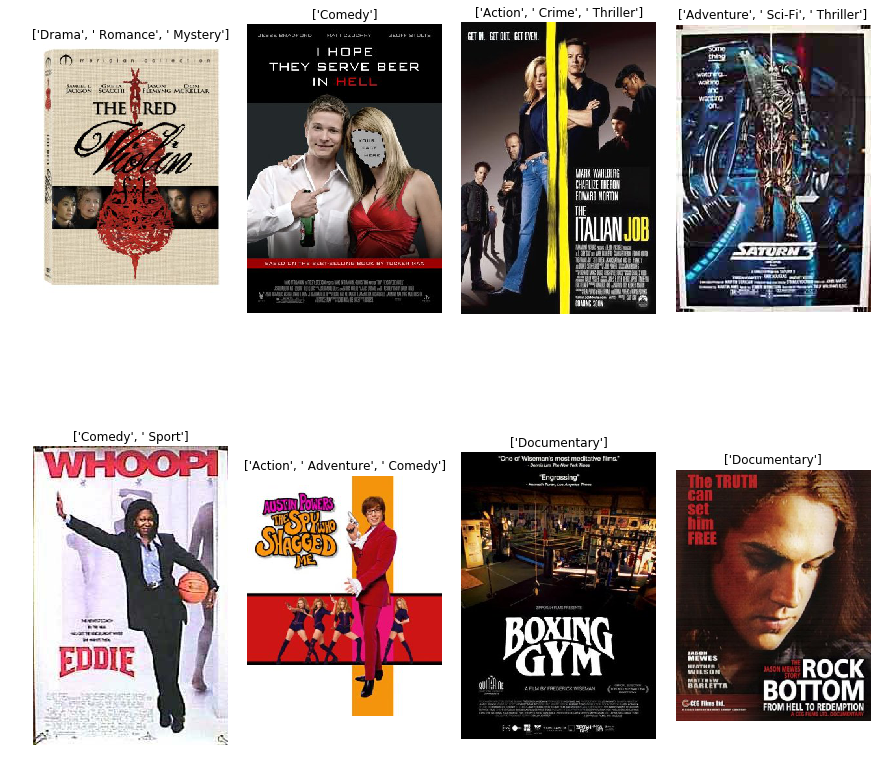

In [0]:
sampledMovies = movieListDatabase.sample(frac=.001)
maxCols = 4
maxRows = sampledMovies.shape[0]//maxCols
fig, axes = plt.subplots(nrows=maxRows, ncols=maxCols, figsize=(15,15))
row = 0
col = 0
for loop in range(sampledMovies.shape[0]):
    img_path = os.path.join(allmoviepostersdata_dir,sampledMovies.iloc[loop]["FileNames"])
    img = mpimg.imread(img_path)
    if (col > (maxCols-1)):
      row = row + 1
      col = 0
    axes[row, col].axis("off")
    axes[row, col].set_title(sampledMovies.iloc[loop]["Genres"])
    axes[row, col].imshow(img)  
    col = col + 1
plt.subplots_adjust(wspace=.10, hspace=.10)
plt.show()

## **Shuffling the dataset**

In [0]:
movieListDatabase = movieListDatabase.sample(frac=1).reset_index(drop=True)

In [0]:
movieListDatabase.head()

FileNames                         Genres
0  tt3966404.jpg                        [Drama]
1  tt0087835.jpg             [Comedy,  Fantasy]
2  tt0120856.jpg  [Action,  Adventure,  Family]
3  tt1609479.jpg               [Comedy,  Drama]
4  tt0167261.jpg   [Action,  Adventure,  Drama]

# **Modelling**

In [0]:
train_datagen=ImageDataGenerator(rescale=1./255.)
valid_datagen=ImageDataGenerator(rescale=1./255.)
targetSize = 200

train_generator=train_datagen.flow_from_dataframe(
      dataframe=trainData,
      directory="/tmp/allmoviepostersdata",
      x_col="FileNames",
      y_col="Genres",
      batch_size=50,
      shuffle=True,
      class_mode="categorical",
      classes=listForFilter,
      target_size=(targetSize,targetSize)
)

valid_generator=valid_datagen.flow_from_dataframe(
      dataframe=validationData,
      directory="/tmp/allmoviepostersdata",
      x_col="FileNames",
      y_col="Genres",
      batch_size=10,
      shuffle=True,
      class_mode="categorical",
      classes=listForFilter,
      target_size=(targetSize,targetSize)
)

Found 7708 validated image filenames belonging to 9 classes.
Found 39 validated image filenames belonging to 9 classes.


In [0]:
maxPooling = 4
filterSize = 3
nodeCount = 64
dropOut = 0.3

model = tf.keras.models.Sequential([                 
    tf.keras.layers.Conv2D(nodeCount, (filterSize, filterSize), activation='relu', input_shape=(targetSize, targetSize, 3), padding="valid"),
    tf.keras.layers.MaxPooling2D(maxPooling, maxPooling),    
    tf.keras.layers.Dropout(dropOut),                 
    tf.keras.layers.Conv2D(nodeCount, (filterSize, filterSize), activation='relu', input_shape=(targetSize, targetSize, 3), padding="valid"),
    tf.keras.layers.MaxPooling2D(maxPooling, maxPooling),       
    tf.keras.layers.Dropout(dropOut),                                         
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(nodeCount, activation=tf.nn.relu), 
    tf.keras.layers.Dense(len(listForFilter), activation=tf.nn.softmax)])

model.compile(optimizer = "adam",
              loss = 'categorical_crossentropy',
              metrics=['accuracy','categorical_crossentropy'])

In [0]:
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 198, 198, 64)      1792      
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 49, 49, 64)        0         
_________________________________________________________________
dropout_77 (Dropout)         (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 47, 47, 64)        36928     
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 11, 11, 64)        0         
_________________________________________________________________
dropout_78 (Dropout)         (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_36 (Flatten)         (None, 7744)            

In [0]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
print("STEP_SIZE_TRAIN :",STEP_SIZE_TRAIN)
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
print("STEP_SIZE_VALID :",STEP_SIZE_VALID)
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=100
)

STEP_SIZE_TRAIN : 154
STEP_SIZE_VALID : 3
Epoch 1/100
154/154 [==============================] - 35s 227ms/step - loss: 1.8478 - accuracy: 0.3317 - categorical_crossentropy: 1.8479 - val_loss: 1.8687 - val_accuracy: 0.3333 - val_categorical_crossentropy: 1.8687
Epoch 2/100
154/154 [==============================] - 34s 219ms/step - loss: 1.7902 - accuracy: 0.3638 - categorical_crossentropy: 1.7873 - val_loss: 1.8539 - val_accuracy: 0.2333 - val_categorical_crossentropy: 1.8539
Epoch 3/100
154/154 [==============================] - 34s 219ms/step - loss: 1.7466 - accuracy: 0.3813 - categorical_crossentropy: 1.7479 - val_loss: 1.8681 - val_accuracy: 0.3333 - val_categorical_crossentropy: 1.8681
Epoch 4/100
154/154 [==============================] - 34s 218ms/step - loss: 1.7033 - accuracy: 0.3961 - categorical_crossentropy: 1.7083 - val_loss: 1.8099 - val_accuracy: 0.3000 - val_categorical_crossentropy: 1.8099
Epoch 5/100
154/154 [==============================] - 34s 218ms/step - loss: 

<Figure size 432x288 with 0 Axes>

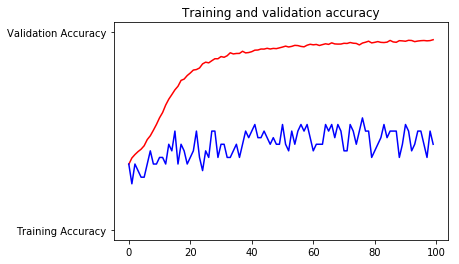

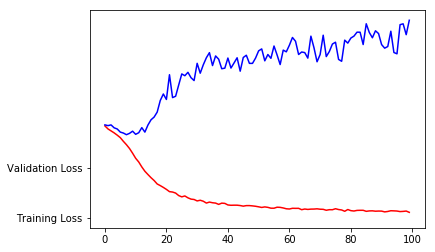

<Figure size 432x288 with 0 Axes>

In [0]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()


# Desired output. Charts with training and validation metrics. No crash :)

Saving Incredibles2.jpeg to Incredibles2 (1).jpeg
Filename : Incredibles2.jpeg
Predicted Movie Genre is  Action
Actual Movie Genre is  Series([], )
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]]


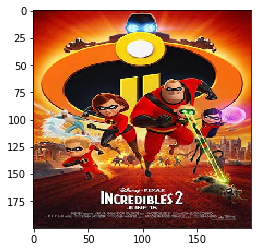

In [0]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

reverseLabelLookup = {value:key for key,value in train_generator.class_indices.items()}

for fn in uploaded.keys():
 
  # predicting images
  print("Filename :",fn)
  path = '/content/' + fn
  img = image.load_img(path, target_size=(200, 200, 3))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  plt.imshow(img)

  print("Predicted Movie Genre is ",reverseLabelLookup[np.argmax(classes)])
  print("Actual Movie Genre is ",movieListDatabase[movieListDatabase["FileNames"]==fn]["Genres"].to_string(index=False))

  print(classes)